# Report from experimental fine-tuning with zpp-murmuras/llama-ds-big_dm dataset
## Output Data Format
As our OpenAPI credits are exhausted we have decided to simplify target data format to enable automated generation of examples.

Now the coupon is represented by following JSON:
```json
{
  "discount_text": "text",
  "product_name": "name",
  "valid_unitl": "validity"
}
```
Where the `discount_text` field is a general field that is filled with the new price, the percentage of the discount or other.

As this change is yet to be consulted with Murmuras, the format might be a subject of future changes.
## Memory issues
It was impossible for me to run the training properly on this dataset without lowering the `per_device_train_batch_size` param from 16 to 8. Additionally, as I had increased the `gradient_accumulation_steps` to 16 from 8, I had to lower batch size further to 4. That suggests that root cause here is related to memory shortage. This is unexpected as metrics on modal showed GPU RAM usage around 4GB, which is afaik way lower than H100 GPU total RAM.
## Hyperparameters
### optimizers
Results of mine finetunings as well as those from [PR #79](https://github.com/ZPP-MURMURAS/ZPP_Murmuras/pull/79) indicate that after first few epochs loss explodes and never reaches initial level. I have observed this anomaly when fine-tuning with optimizer from adam family or rmsprop. SGD on the other hand has no problem with it. Usually this phenomenon is observed with a gradient explosion.

I have tried lowering lr, playing with adam params, clipping the gradient, lowering the weight decay rate, changing gradient accumulation steps and running with different lr schedulers, but with little result. My experiments were far from being exhaustive, but at this moment I recommend using SGD.
### lr schedulers
From my experience the `constant` scheduler outperforms other ones for 30 epochs. This probably will change if we will run the training with a greater number of epochs.
## Costs
The experiments performed costed me around $13 in Modal credits. As I performed more than 15 runs, each consisting of 30 epochs, the training costs were lower than our original estimations.

In [13]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
wandb.login()

wandb: Currently logged in as: sf-kozlowski (sf-kozlowski-university-of-warsaw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [17]:
PROJECT_NAME = 'llama-finetune-dm'
CONST_LR_COMP = [
    'lion_8bit, constant lr',
    'adamw_8bit, constant lr',
    'rmsprop, constant lr',
    'sgd, constant lr'
]
ADAMW_ATTEMPTS = [
    'adam2_8bit, constant_with_warmup lr clip=0.1 decay=0.001',
    'adamw_8bit, constant lr, gradient clipping',
    'adamw_8bit, constant lr',
    'adamw_8bit, constant_with_warmup lr',
    'adamw_8bit, cosine lr'
]
SGD_ATTEMPTS = [
    'sgd, constant lr',
    'sgd, cosine lr'
]
COMPARISONS = {
    'Constant Learning Rate, different optimizers': CONST_LR_COMP,
    'AdamW optimizer experiments': ADAMW_ATTEMPTS,
    'SGD optimizer experiments': SGD_ATTEMPTS
}


In [40]:
# credits to GustawB
def plot_runs_data(runs, metric, runs_active, log_scale=False):
    plt.figure(figsize=(10, 5))
    if log_scale:
        plt.yscale('log')
    for run in runs:
        if run.name in runs_active:
            history = run.history()
            series = history[metric].to_numpy()
            mask = np.isnan(series)
            series[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), series[~mask])
            plt.plot(history["_step"], series, label=f"Run: {run.name}")

    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.title(f"{metric} across Runs")
    plt.legend()
    plt.grid()
    plt.show()
api = wandb.Api()

In [37]:
runs = api.runs(f"{wandb.Api().default_entity}/{PROJECT_NAME}")

# Metrics Comp for different optimizers with constant learning rate scheduler

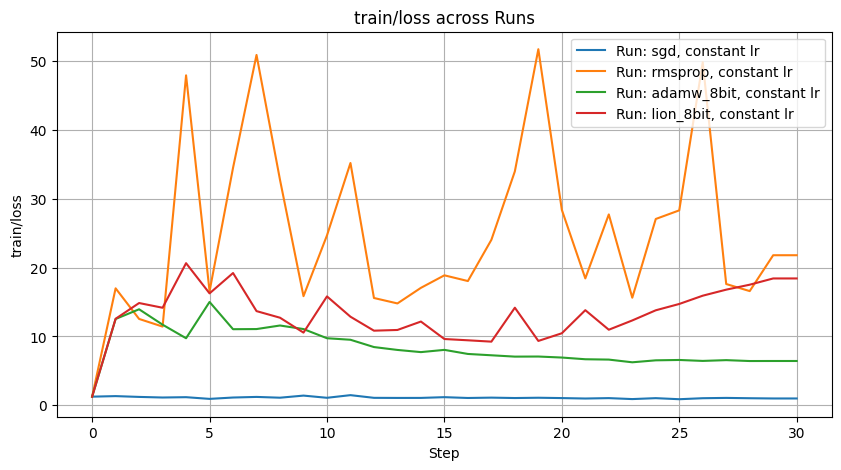

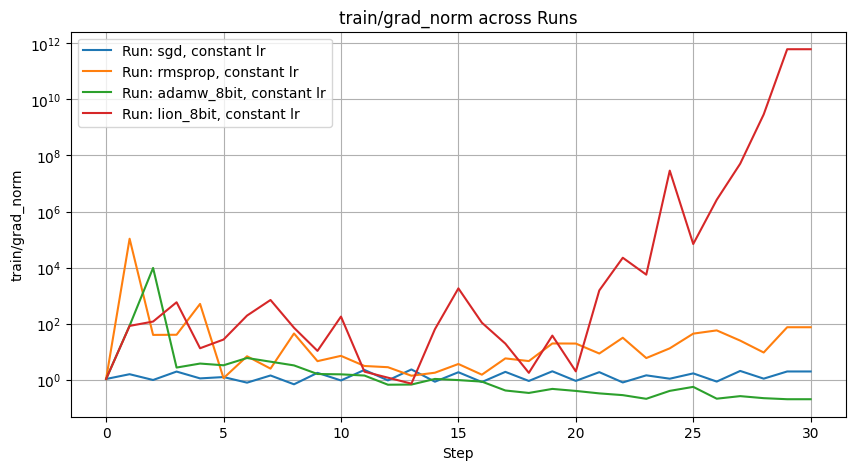

In [23]:
plot_runs_data(runs, 'train/loss', runs_active=COMPARISONS["Constant Learning Rate, different optimizers"])
plot_runs_data(runs, 'train/grad_norm', runs_active=COMPARISONS["Constant Learning Rate, different optimizers"], log_scale=True)

# Metrics Comp for experiments with AdamW

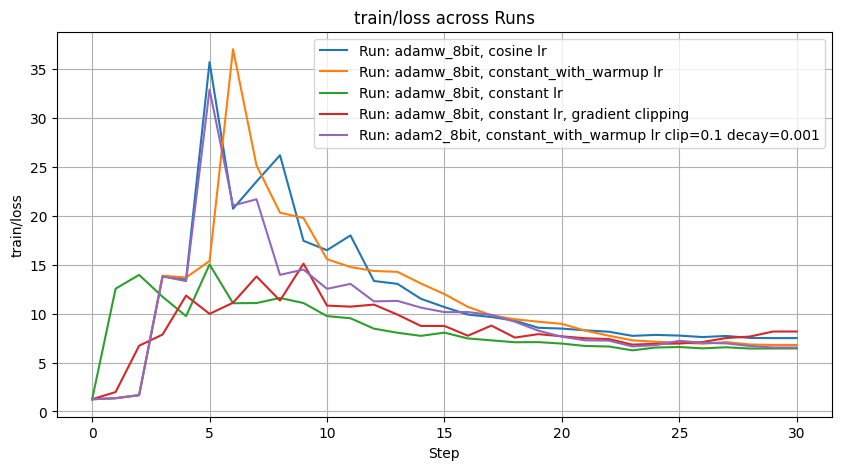

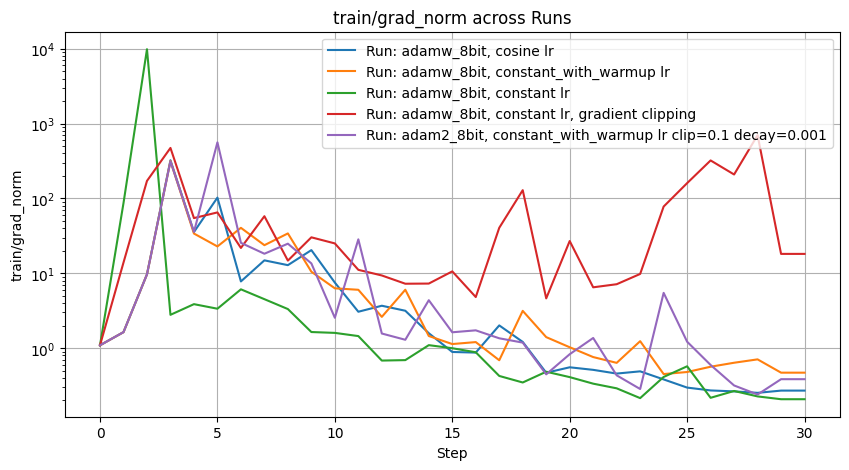

In [24]:
plot_runs_data(runs, 'train/loss', runs_active=COMPARISONS["AdamW optimizer experiments"])
plot_runs_data(runs, 'train/grad_norm', runs_active=COMPARISONS["AdamW optimizer experiments"], log_scale=True)

# Metrics Comp for experiments with SGD

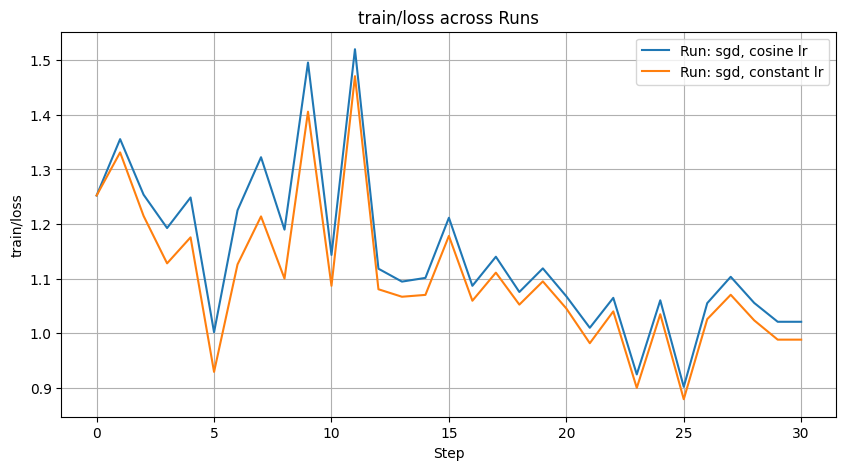

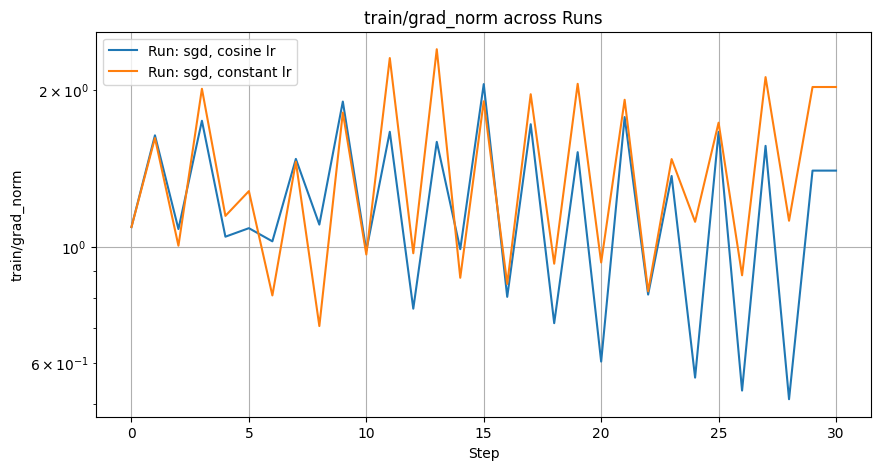

In [25]:
plot_runs_data(runs, 'train/loss', runs_active=COMPARISONS["SGD optimizer experiments"])
plot_runs_data(runs, 'train/grad_norm', runs_active=COMPARISONS["SGD optimizer experiments"], log_scale=True)

# Update
I have conducted more experiments with lowered lr.

In [26]:
PROJECT_NAME = 'llama-finetune-dm-2'
LR_COMP = [
    'adamw_8bit lr=3e-2',
    'adamw_8bit lr=3e-3',
    'adamw_8bit lr=3e-4',
    'adamw_8bit lr=3e-5'
]
OPTIMIZERS_COMP = [
    'rmsprop_bnb_8bit lr=3e-4',
    'sgd lr=3e-4',
    'lion_8bit lr=3e-4',
    'adamw_8bit lr=3e-4'
]
LORA_DROPOUTS_COMP = [
    'lion_8bit lr=3e-4 dropout=0.5',
    'lion_8bit lr=3e-4 dropout=0.1',
    'lion_8bit lr=3e-4'
]
LORA_R_COMP = [
    'lion_8bit linear r=8',
    'lion_8bit lr=3e-4'
]
LR_SCHEDULERS_COMP = [
    'constant lion_8bit lr=3e-4 dropout=0.1',
    'lion_8bit lr=3e-4 dropout=0.1',
    'cosine lion_8bit lr=3e-4 dropout=0.1'
]
DECAY_COMP = [
    'lion_8bit lr=3e-4',
    'lion_8bit lr=3e-4 decay=0.03'
]

runs2 = api.runs(f"{wandb.Api().default_entity}/{PROJECT_NAME}")


Note: the baseline training configuration in the following experiments is as follows:
* lora config:
* * `dropout=0.0`
* * `r=16`
* training config:
* * `learning_rate=3e-4`
* * `optim=lion_8bit` (see [this paper](https://arxiv.org/abs/2302.06675))
* * `weight_decay=0.01`
* * `lr_scheduler="linear"`

If some hyperparemeters are not mentioned in the following comparisons, they are set to the above values.

Additionally, I recommend the values above as a configuration to longer finetuning runs.
## Learning rate exploration
I have checked how training behaves with different learning rate:

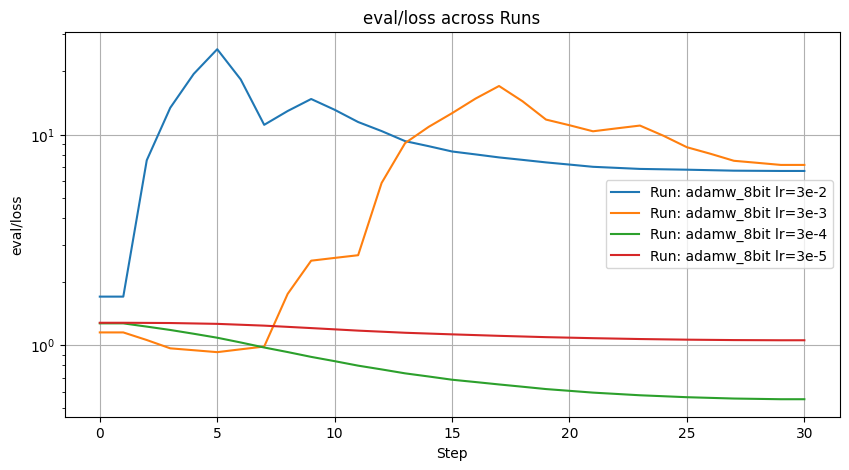

In [27]:
plot_runs_data(runs2, 'eval/loss', runs_active=LR_COMP, log_scale=True)

## Optimizer comparison
As the `lr=3e-4` performs the best, I have picked this value for further experiments. Here is comparison of different optimizers:

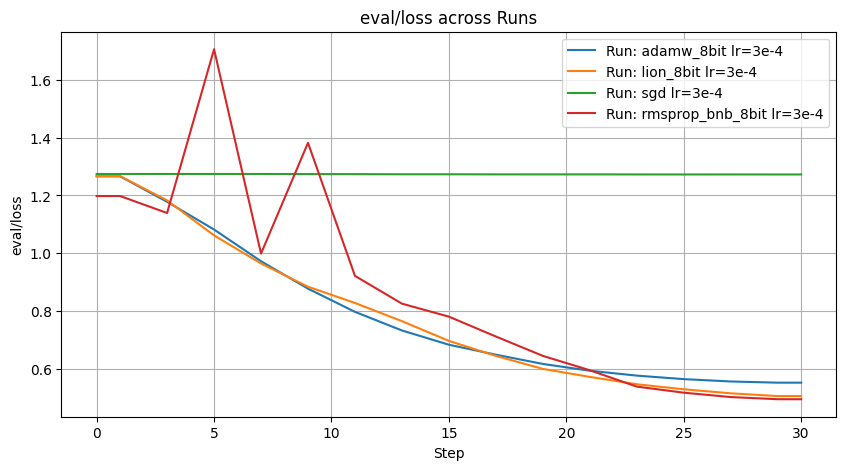

In [28]:
plot_runs_data(runs2, 'eval/loss', runs_active=OPTIMIZERS_COMP, log_scale=False)

The best performing optimizers are RMSProp and Lion. However, RMSProp loss is strangely exploding in the initial steps, so I recommed using lion in further fine-tunings.
It might look like the learning rate is too small for the SGD optimizer. Let's check how the training loss behaves:

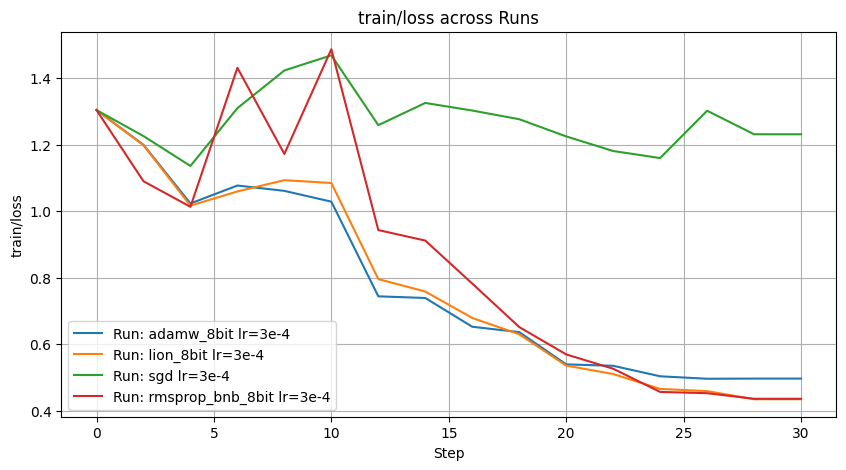

In [29]:
plot_runs_data(runs2, 'train/loss', runs_active=OPTIMIZERS_COMP, log_scale=False)

The loss for SGD is fluctuating, so I assume that the weight updates are not too small and SGD is simply outperformed by other optimizers.
## LoRA dropout experiments
Some sources if you need an introduction to [LoRA](https://towardsdatascience.com/understanding-lora-low-rank-adaptation-for-finetuning-large-models-936bce1a07c6/) and [LoRA dropout](https://arxiv.org/abs/2404.09610)

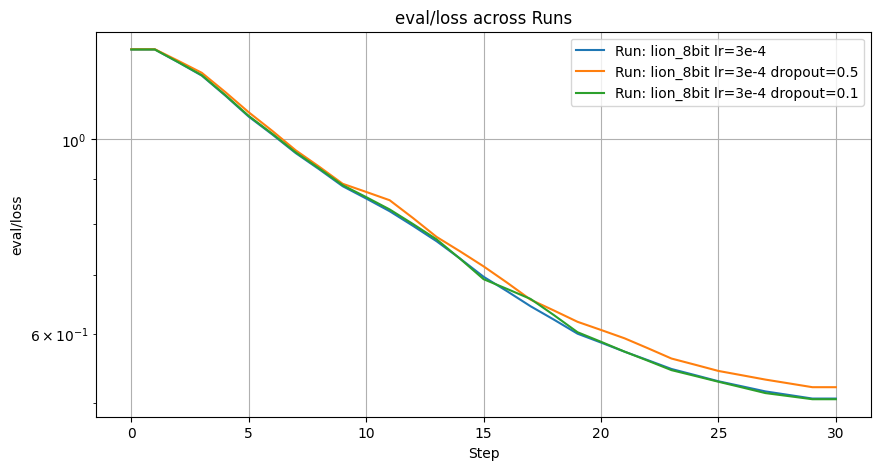

In [30]:
plot_runs_data(runs2, 'eval/loss', runs_active=LORA_DROPOUTS_COMP, log_scale=True)

## LoRA r parameter comparison

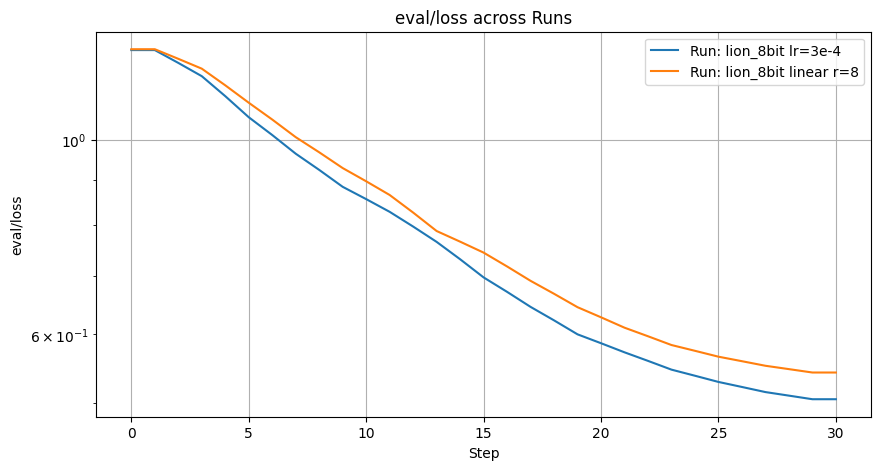

In [31]:
plot_runs_data(runs2, 'eval/loss', runs_active=LORA_R_COMP, log_scale=True)

lowering `r` to 8 from 16 impacted performance. We have to remember that `r` is directly affecting number of trainable parameters, so this does not mean necessarily that we want to use `r=16`.
# LR schedulers comparison
This comparison was made with `dropout=0.1`

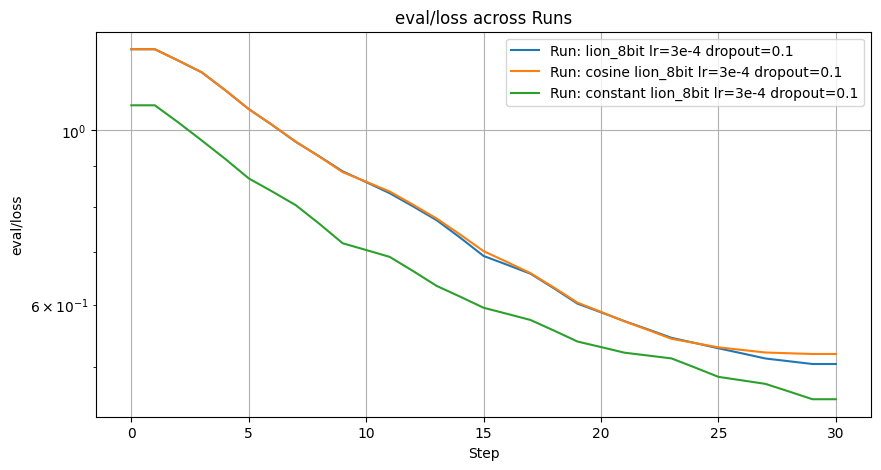

In [32]:
plot_runs_data(runs2, 'eval/loss', runs_active=LR_SCHEDULERS_COMP, log_scale=True)

We see that `constant` scheduler achieves the lowest loss. Despite that, I am far from recommending it, especially in longer runs.

## Weight decay rate comp

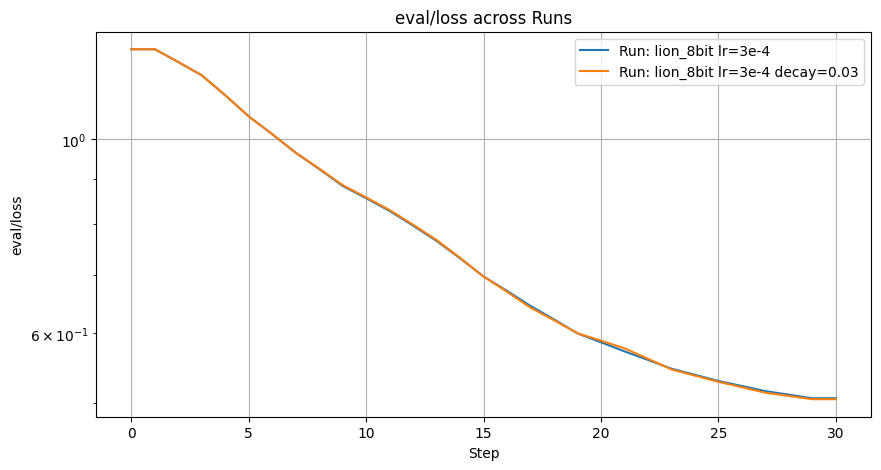

In [33]:
plot_runs_data(runs2, 'eval/loss', runs_active=DECAY_COMP, log_scale=True)

# Extended coupon format fine-tuning
Here are some basic experiments with fine-tuning on the extended format DM dataset.

In [38]:
PROJECT_NAME = "llama-finetune-dm-ext"
runs3 = api.runs(f"{wandb.Api().default_entity}/{PROJECT_NAME}")

## Optimizers Comparison

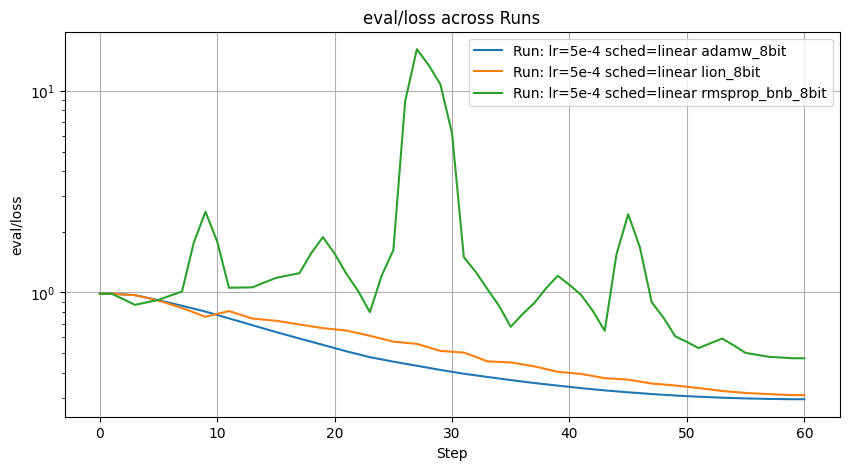

In [41]:
plot_runs_data(runs3, 'eval/loss', [
    'lr=5e-4 sched=linear rmsprop_bnb_8bit',
    'lr=5e-4 sched=linear adamw_8bit',
    'lr=5e-4 sched=linear lion_8bit'
], True)

Now the adamw optimizer is the best one.
## lr scheduler comparison

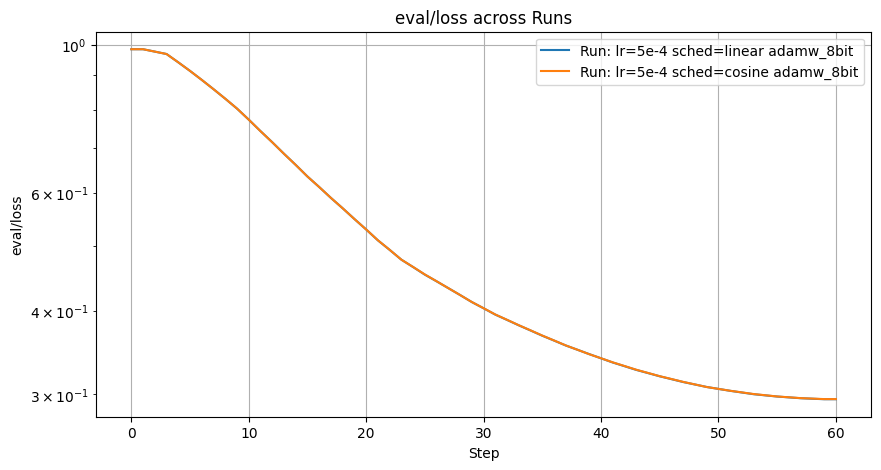

In [42]:
plot_runs_data(runs3, 'eval/loss', [
    'lr=5e-4 sched=cosine adamw_8bit',
    'lr=5e-4 sched=linear adamw_8bit',
], True)

There is no visible difference between them
## Lower loss on more complex coupon format - possible explanations
### More boilerplate to predict
As the coupon format contains more fields, an opportunity for model appears to boost its score by predicting it. However, this should be compensated if nonzero values of fields are frequent - mispredicting them will in this case reduce any gain on boilerplate.

Lets check how frequent empty fields are in both datasets:

In [2]:
import datasets
import os
import json
from math import nan
from ast import literal_eval
HF_TOKEN = os.getenv("HF_API_KEY")
ds_ext = datasets.load_dataset('zpp-murmuras/llama-ds-big-dm-extended-format', token=HF_TOKEN)
ds = datasets.load_dataset('zpp-murmuras/llama-ds-big_dm', token=HF_TOKEN)
def count_nonempty_fields(dataset):
    total = 0
    non_empty = 0
    for sample in dataset:
        formatted = sample['Response'].replace(": nan", ": \"\"")
        try:
            as_json = literal_eval(formatted)
        except Exception as e:
            print(formatted)
            raise e
        for coupon in as_json:
            for k, v in coupon.items():
                if v not in ['None', 'nan', '', nan, None]:
                    non_empty += 1
                total += 1
    return non_empty / total * 100

print(f"extended dataset has {count_nonempty_fields(ds_ext['test'])}% of nonempty fields")
print(f"short format dataset has {count_nonempty_fields(ds['test'])}% of nonempty fields")


extended dataset has 50.01540832049307% of nonempty fields
short format dataset has 89.10675381263616% of nonempty fields


|This result suggests that the stated hypothesis can be true.
### More reasonable fields
The performance gain might also be caused by the fact that in extended format we omit the `discount_text` field, which might contain wide range of information and be harder to retrieve to model as a result.
# Example evaluation of fine-tuned model
Note: llama-cli installed on your machine is required to run this example


In [ ]:
example_ext = ds_ext['test'][69]

